In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import odeint
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams.update({'font.size' : 18})

In [25]:
# internal Library

def tridiag(sub_diag, diag, super_diag, n):
    """
    Return tridiagonal matrix.

    INPUT
        sub_diag: sub-diagonal elements
        diag: diagonal elements
        super_diag: super-diagonal elements
        n: size of the matrix
    OUTPUT
        A: tridiagonal matrix
    """
    A = np.zeros((n,n)) # create an empty zeroes matrix
    np.fill_diagonal(A, diag) # fill the diagonal
    np.fill_diagonal(A[1:,:], sub_diag) # fill the lower diagonal
    np.fill_diagonal(A[:,1:], super_diag) # fill the upper diagonal

    return A

Heat equation takes the form $u_t = du_xx$ such that k is a thermal diffusion constant. We can transform the entire equation into fourier space by taking the fourier transform of the heat equation giving us
$$
\hat{u_t}(k, t) = \frac{\partial}{\partial t}\hat{u}(x,t)
$$
and the definition of the fourier transform is $\hat{u}(k,t) = \int_\mathbb{R}u(x,t)e^{-ikx}dx$ so for the temporal derivative, since the exponential is not dependent in $t$, we have 
$$
\hat{u_t}(k, t) = \int_\mathbb{R}\frac{\partial}{\partial t}u(x,t)e^{-ikx}dx = \frac{\partial}{\partial t}\int_\mathbb{R}u(x,t)e^{-ikx}dx = (\hat{u}(k,t))_t
$$

For the spatial domain, we need the second derivative with respect to $x$, we have to use integration by parts twice:

$$
\hat{u_{xx}}(k,t) = \int_\mathbb{R}u_{xx}e^{-ikx}dx = -\int_\mathbb{R}(ik)^2ue^{-ikx}dx
= (ik)^2\hat{u}(k,t) = -k^2\hat{u}(k,t)
$$

In [26]:
# code inspired by Steve Brunton and "Data-driven Science and Engineering"
d = 1 # thermal diffusivity
L = 20. # 100 # domain length
N = 1000 # spatial discretization points
dx = L / N # change in x
x = np.arange(-L/2, L/2, dx) # x domain

# discrete wave numbers
omega = 2 * np.pi * np.fft.fftfreq(N, d = dx)

# initial condition
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

# concatenate the real and imaginary parts into one other variable, keeping the structure of both
u0hat_ri = np.concatenate((u0hat.real, u0hat.imag))

# simulate Fourier frequency domain 
dt = 0.0001
T = 1 # final time 
t = np.arange(0, T, dt)

def rhsHeat(uhat_ri, omega, d):
    uhat = uhat_ri[:N] + 1j * uhat_ri[N:]
    uhat_t = -d * d * omega**2 * uhat
    return np.concatenate((uhat_t.real, uhat_t.imag)).astype('float64')

def rk4_step(uhat_ri, t, dt, omega, d):
    k1 = rhsHeat(uhat_ri, omega, d)
    k2 = rhsHeat(uhat_ri + 0.5 * dt * k1, omega, d)
    k3 = rhsHeat(uhat_ri + 0.5 * dt * k2, omega, d)
    k4 = rhsHeat(uhat_ri + dt * k3, omega, d)
    return uhat_ri + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

# Simulation loop
uhat_ri = u0hat_ri
results = []
for time in t:
    uhat_ri = rk4_step(uhat_ri, time, dt, omega, d)
    uhat = uhat_ri[:N] + 1j * uhat_ri[N:]
    u = np.fft.ifft(uhat)
    results.append(np.real(u))

/var/folders/xh/4xpwy9dj7glg3lpzyn0wwqgw0000gn/T/ipykernel_9753/1952551648.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("CMRmap")


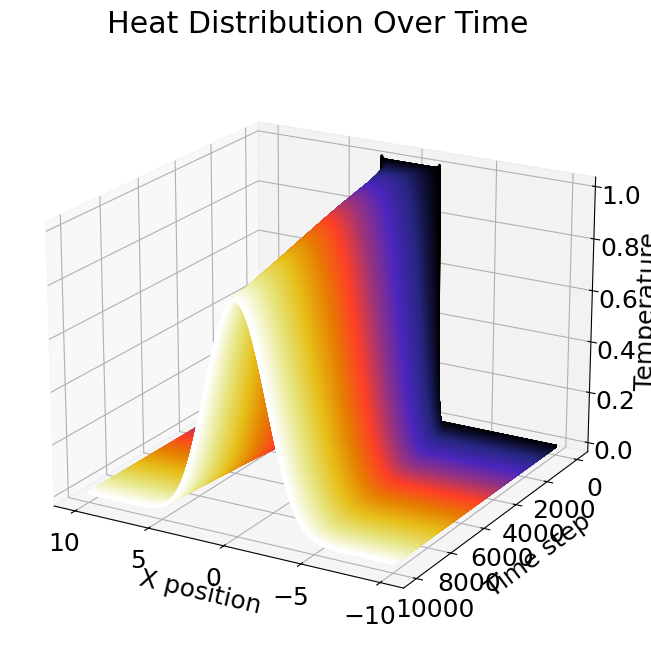

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Convert results into a numpy array
results = np.array(results)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color to white

# Create a colormap and a normalization instance
norm = Normalize(vmin=0, vmax=T)
color_map = cm.get_cmap("CMRmap")

time_steps = len(t)

# Plotting each time step
for j in range(time_steps):
    ys = j * np.ones(N)  # Create a line at each time step
    color = color_map(norm(t[j]))  # Apply colormap normalization to the time value
    ax.plot(x, ys, results[j], color=color, linewidth=2)

# Set labels and title
ax.set_xlabel('X position')
ax.set_ylabel('Time step')
ax.set_zlabel('Temperature')
ax.set_title('Heat Distribution Over Time')

# Adjust the viewing angle
ax.view_init(elev=20, azim=120)

# Display the plot
plt.show()


/var/folders/xh/4xpwy9dj7glg3lpzyn0wwqgw0000gn/T/ipykernel_9753/2643832671.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("CMRmap")


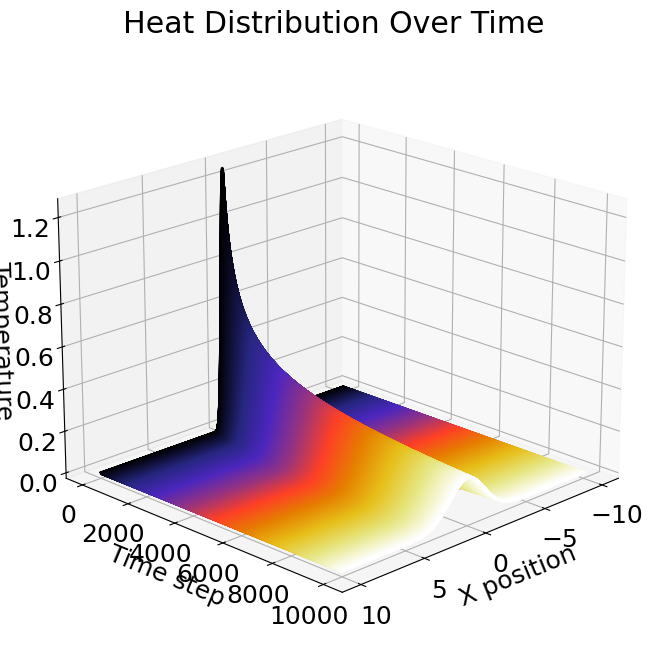

In [28]:
# code inspired by Steve Brunton and "Data-driven Science and Engineering"


d = 1 # thermal diffusivity
L = 20 # domain length
N = 1000 # spatial discretization points
dx = L / N # change in x
x = np.arange(-L/2, L/2, dx) # x domain

# discrete wave numbers
omega = 2 * np.pi * np.fft.fftfreq(N, d = dx)

# initial condition
u0 = np.zeros_like(x)
u0[:] = np.exp(-x*x/(2.*0.05))/np.sqrt(4.*np.pi*0.05)
u0hat = np.fft.fft(u0)

# concatenate the real and imaginary parts into one other variable, keeping the structure of both
u0hat_ri = np.concatenate((u0hat.real, u0hat.imag))

# simulate Fourier frequency domain 
dt = 0.0001
T = 1 # final time 
t = np.arange(0, T, dt)

def rhsHeat(uhat_ri, omega, d):
    uhat = uhat_ri[:N] + 1j * uhat_ri[N:]
    uhat_t = -d * d * omega**2 * uhat
    return np.concatenate((uhat_t.real, uhat_t.imag)).astype('float64')

def rk4_step(uhat_ri, t, dt, omega, d):
    k1 = rhsHeat(uhat_ri, omega, d)
    k2 = rhsHeat(uhat_ri + 0.5 * dt * k1, omega, d)
    k3 = rhsHeat(uhat_ri + 0.5 * dt * k2, omega, d)
    k4 = rhsHeat(uhat_ri + dt * k3, omega, d)
    return uhat_ri + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

# Simulation loop
uhat_ri = u0hat_ri
results = []
for time in t:
    uhat_ri = rk4_step(uhat_ri, time, dt, omega, d)
    uhat = uhat_ri[:N] + 1j * uhat_ri[N:]
    u = np.fft.ifft(uhat)
    results.append(np.real(u))

# Convert results into a numpy array
results = np.array(results)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color to white

# Create a colormap and a normalization instance
norm = Normalize(vmin=0, vmax=T)
color_map = cm.get_cmap("CMRmap")

time_steps = len(t)

# Plotting each time step
for j in range(time_steps):
    ys = j * np.ones(N)  # Create a line at each time step
    color = color_map(norm(t[j]))  # Apply colormap normalization to the time value
    ax.plot(x, ys, results[j], color=color, linewidth=2)

# Set labels and title
ax.set_xlabel('X position')
ax.set_ylabel('Time step')
ax.set_zlabel('Temperature')
ax.set_title('Heat Distribution Over Time')

# Adjust the viewing angle
ax.view_init(elev=20, azim=45)

# Display the plot
plt.show()


In [29]:
# Using scipy's odeint, idea referenced from Steve Brunton's video https://www.youtube.com/watch?v=hDeARtZdq-U 

a = 1 # thermal diffusivity coefficient
L = 100 # length of the domain
N = 1000 # number of spatial points
dx = L / N
x = np.arange(-L/2, L/2, dx) # create points in an x axis

# Create signal numbers
omega = 2. * np.pi * np.fft.fftfreq(N, d  = dx)

# Initial condition box wave with height intial height of 1
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1

# Perform FFT on initial wave
u0hat = np.fft.fft(u0)

# using scipy odeint for now, change to other ode solver method
u0hat_split = np.concatenate((u0hat.real, u0hat.imag))

In [30]:
# Frequencies for time domain
dt = 0.1
t = np.arange(0, 10, dt)

# solve equation using fft with real and imaginary parts
def rhsHeat(uhat_split, t, omega, a):
    uhat = uhat_split[:N] + (1j) * uhat_split[N:]
    d_uhat = -a**2 * (np.power(omega, 2)) * uhat
    d_uhat_split = np.concatenate((d_uhat.real, d_uhat.imag)).astype('float64')
    return d_uhat_split

# use scipy's ode solver to compute solution of fft transformation
uhat_split = odeint(rhsHeat, u0hat_split, t, args = (omega, a))

# Simulation loop
uhat_split = u0hat_split
results = []
for time in t:
    uhat_split = rk4_step(uhat_split, time, dt, omega, a)
    uhat = uhat_split[:N] + 1j * uhat_split[N:]
    u = np.fft.ifft(uhat)
    results.append(np.real(u))

TypeError: rhsHeat() missing 1 required positional argument: 'a'

In [ ]:
# Convert results into a numpy array
results = np.array(results)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color to white

# Create a colormap and a normalization instance
norm = Normalize(vmin=0, vmax=T)
color_map = cm.get_cmap("CMRmap")

time_steps = len(t)

# Plotting each time step
for j in range(time_steps):
    ys = j * np.ones(N)  # Create a line at each time step
    color = color_map(norm(t[j]))  # Apply colormap normalization to the time value
    ax.plot(x, ys, results[j], color=color, linewidth=2)

# Set labels and title
ax.set_xlabel('X position')
ax.set_ylabel('Time step')
ax.set_zlabel('Temperature')
ax.set_title('Heat Distribution Over Time')

# Adjust the viewing angle
ax.view_init(elev=20, azim=45)

# Display the plot
plt.show()

# Backward Finite Difference Method Solver - Heat Equation
**Now comparing to Backward Heat equation. One could inspect further the advancements and stability of the Crank Nicolson method, however with time, this was hard to implement and focus on**

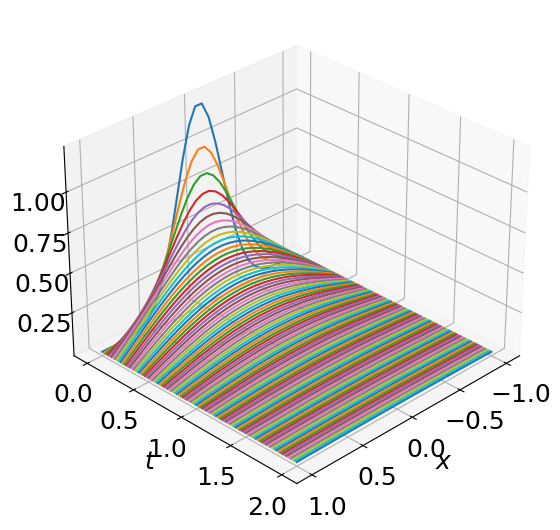

In [ ]:
# code from 104B, FDM for Heat equation
def backward_FDM(w, par):
    """
    Return the next time iterate of the heat equation using backward difference method.
    
    Input:
        w: (1D array) Temperature distribution at time t.
        par: (dict) Parameter for the forward difference method.
    Output:
        w_new: (1D array) Temperature distribution at time t+1.
    """
    # extract parameters
    s = par['D']*par['k']/(par['h']*par['h'])
    bc1 = par['bc1']
    bc2 = par['bc2']

    w_new = np.zeros_like(w[1:-1])
    b = w[1:-1].copy() # Solution vector

    # Construct the matrix A
    A = tridiag(-s, 1+2*s, -s, len(b))

    # Can use np.linalg.solve to solve the system to update our w vector
    w_new = np.linalg.solve(A, b)
    return w_new

def solve_diffusion(ic, bc1, bc2, D, a, b, T, N, K, t0=0.):
    """
    Return numerical solution of Heat Equation using backward or forward Difference Method
    Inputs:
        ic: (1d Array) Initial Distribution
        bc1, bc2: (float or 1d array) Boundary condition at x = a, b
        a, b: (float) left and right boundarys 
        D: (float) Diffusion Coefficient
        T: (float) Final time
        N: (int) Number of spatial grid point
        K: (int) Number of time grid points
        t0: (float) intial time set to t0 = 0
        method: (str) 'forward' or 'backward'
    """
    w = np.zeros((N+2, K+1)) # account for 2 initial boundaries and one init cond at t = 0
    h = (b-a) / (N+1)
    k = (T-t0) / K

    par = {'D': D, 'h':h, 'k':k, 'bc1':bc1, 'bc2':bc2}


    # Initial conditions and boundary conditions
    w[:,0], w[0,:], w[-1,:] = ic, bc1, bc2

    # Time marching
    for j in range(K):
        w[1:-1, j+1] = backward_FDM(w[:,j], par=par)
    return w

N = 30
K = 100
a = -1.
b = 1.
D = 1.
T = 2. 
x = np.linspace(a, b, N+2)
t = np.linspace(0, T, K+1)

f = lambda m, x: np.exp(-x*x/(2.*m))/np.sqrt(4.*np.pi*m)
m = .05
ic = f(m, x)
bc1 = f(m, a)
bc2 = f(m, b)

w = solve_diffusion(ic, bc1, bc2, D, a, b, T, N, K)

#%% plot
fig, ax = plt.subplots(1,1, figsize=(6.5, 6.5), subplot_kw={'projection':'3d'})

for j in range(K+1):
    ax.plot(x, t[j]*np.ones(N+2), w[:, j])

# Change the angle of projection

ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.view_init(elev=30, azim=45)

plt.show()